# ROV Battery Pack Optimization
The task in this tutorial is to find the optimal configuration of N battery cells in a battery pack that powers an ROV. Optimal in this case means the lowest power consumption for a set of defined use cases.


In [1]:
# This cell can be removed, it is only used for running the notebook during Sphinx documentation build.
import sys, os
if os.getcwd().replace('\\', '/').endswith("/docs/nb"):
    sys.path.insert(0, os.path.abspath(os.path.join("../../src")))

In [2]:
from sysloss.components import *
from sysloss.system import System
import pandas as pd
import matplotlib.pyplot as plt

## System definition
The ROV consists of the following parts and modules:
  * LED light, dimmable, 24V 1.32A (max)
  * Camera, 12V, 0.3A
  * Sonar, 24V, 7W
  * 6x 12V thrusters (two upwards, four tilting), 8A max current each 
  * Control and comms module, 5V, 0.5W
  * Battery pack

Three voltage converters are used to convert the battery pack voltage to 5V, 12V and 24V respectively.

The ROV has space for 24 rechargeable lithium battery cells. The nominal battery voltage is 3.7V. A fully charged battery can be 4.2V and the battery voltage cutoff is 3.0V. Each cell has a capacity of 5Ah. To prolong battery life, the discharge current from each cell should not exceed 1C.  
Let's start by defining the battery parameter constants:

In [3]:
BATT_NOM = 3.7 # Volt
BATT_MAX = 4.2 # Volt
BATT_MIN = 3.0 # Volt
BATT_CAP = 5.0 # Ah
BATT_RC = 20e-3 # connection resistance (Ohm)

The battery pack will be organized as *nPmS*, where *n* i the number of batteries in parallel and *m* is the number of batteries in series:  
![](bpack.svg)

The bus bar (nickel strip) resistance is ignored for simplicity. The connection resistance, *Rc*, is 20mOhm. And the battery internal resistance, *Rs*, is set to 50mOhm initially. The total pack resistance is then:  
$$
R_{pack}=\frac{(2R_{c}+R_{s})m}{n}\
$$

During ROV operation the camera and the control/communications module are always on. The other modules are utilized according to the following use cases:
  * Roam: Thrusters at 50%, sonar is off, LED light is 30%
  * Scan: Thrusters at 25%, sonar is on, LED light is 50%
  * Inspect: Thrusters at 33%, sonar is off, LED light is 100%

Average percentage of time spent per use case during ROV operation is:
  * Roam: 25%
  * Scan: 60%
  * Inspect: 15%

Define the system load phases that represent the use cases. For duration, we define a 10min interval as the total time for the three phases:
```{tip}
Load phase duration is used for both calculation of time-weighted average of total system power and during battery depletion in battery life estimation. In the former case the sum of phase times does not impact the calculation, but in the latter case the sum of phase times should be scaled such that each phase will be analyzed multiple times during battery depletion.
```

In [4]:
rov_phases = {"roam": 150, "scan": 360, "inspect": 90}

Next, we define the efficiency curves for the DC/DC converters:

In [5]:
bb_24v_eff = {"vi":[5.0, 12.0, 24.0, 48.0], 
              "io":[0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 3.0, 5.0], 
              "eff":[[0.2, 0.55, 0.71, 0.825, 0.91, 0.93, 0.94, 0.93, 0.9],
                     [0.12, 0.4, 0.57, 0.72, 0.85, 0.91, 0.93, 0.94, 0.945],
                     [0.1, 0.35, 0.52, 0.68, 0.84, 0.9, 0.925, 0.94, 0.95],
                     [0.08, 0.17, 0.3, 0.45, 0.67, 0.78, 0.85, 0.88, 0.89]]}

bb_12v_eff = {"vi":[6.0, 12.0, 24.0, 36.0, 60.0],
              "io":[0.1, 10., 20., 30., 40., 50.],
              "eff":[[0.86, 0.94, 0.955, 0.96, 0.95, 0.94],
                     [0.84, 0.93, 0.95, 0.955, 0.955, 0.94],
                     [0.82, 0.92, 0.94, 0.945, 0.95, 0.95],
                     [0.78, 0.88, 0.925, 0.935, 0.94, 0.94],
                     [0.7, 0.84, 0.87, 0.91, 0.92, 0.925]]}

buck_5v_eff = {"vi":[6.0, 12.0, 24.0, 48.0],
               "io":[0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12],
               "eff":[[0.25, 0.85, 0.92, 0.93, 0.94, 0.95, 0.95],
                      [0.1, 0.82, 0.89, 0.91, 0.92, 00.93, 0.92],
                      [0.07, 0.69, 0.8, 0.84, 0.87, 0.88, 0.89],
                      [0.05, 0.5, 0.66, 0.74, 0.78, 0.81, 0.82]]}

Finally, we create a function that sets up the ROV system. The parameters to this function are:
  * n: number of cells in parallel
  * m: number f cells in series
  * rc: cell connection resistance
  * rs: cell internal resistance
  * cv: cell voltage
  * cc: cell capacity

```{tip}
Add a value for the thermal resistance parameter (rt) on components that should be monitored for temperature rise. Combine this with a limit on temperature rise (tr) to get warnings if components get too hot.
```

In [6]:
def create_rov(n, m, rc, rs, cv, cc, phases):
    """ROV system creation"""
    rpack = m*(2*rc+rs)/n
    vpack = m*cv
    sys = System("ROV", source=Source("BattPack", vo=vpack, rs=rpack, limits={"io":[0, cc*n]}))
    sys.set_sys_phases(phases)
    sys.add_comp("BattPack", comp=Converter("Buck-boost 24V", vo=21.6, eff=bb_24v_eff, rt=0.8,
                                            limits={"vi":[3.5, 55.0], "io":[0.0, 5.0], "pl":[0.0, 6.0], "tr":[0.0, 15.0]}))
    sys.add_comp("Buck-boost 24V", comp=ILoad("Light", ii=1.32))
    sys.set_comp_phases("Light", phase_conf={"roam": 0.396, "scan": 0.66, "inspect":1.32})
    sys.add_comp("Buck-boost 24V", comp=PLoad("Sonar", pwr=7.0))
    sys.set_comp_phases("Sonar", phase_conf={"scan": 7.0})
    sys.add_comp("BattPack", comp=Converter("Buck-boost 12V", vo=12.0, eff=bb_12v_eff, rt=1.5, 
                                            limits={"vi":[6., 60.], "io":[0.0, 50.0], "pl":[0.0, 40.0], "tr":[0.0, 40.0]}))
    sys.add_comp("Buck-boost 12V", comp=ILoad("Thrusters", ii=15.0))
    sys.set_comp_phases("Thrusters", phase_conf={"roam": 24.0, "scan": 12.0, "inspect":15.84})
    sys.add_comp("Buck-boost 12V", comp=ILoad("Camera", ii=0.3))
    sys.add_comp("BattPack", comp=Converter("Buck 5V", vo=5.0, eff=buck_5v_eff, limits={"vi":[3., 65.], "io":[0.0, 0.12], "pl":[0.0, 1.2]}))
    sys.add_comp("Buck 5V", comp=PLoad("Control", pwr=0.5))
    return sys

## Parameter check
```{tip}
It is always a good idea to check the system creation function and system parameters before starting system analysis.
```
Let's create a test system and use `sysLoss` built-in review methods:

In [7]:
rov = create_rov(6, 4, BATT_RC, 50e-3, BATT_NOM, BATT_CAP, rov_phases)
rov.tree()

ROV
└── BattPack
    ├── Buck 5V
    │   └── Control
    ├── Buck-boost 12V
    │   ├── Camera
    │   └── Thrusters
    └── Buck-boost 24V
        ├── Sonar
        └── Light

In [8]:
rov.phases()

,Component,Type,Parent,Active phase,rs (Ohm),ii (A),pwr (W)
0,BattPack,SOURCE,,N/A,,,
1,Buck 5V,CONVERTER,BattPack,N/A,,,
2,Control,LOAD,Buck 5V,N/A,,,0.5
3,Buck-boost 12V,CONVERTER,BattPack,N/A,,,
4,Camera,LOAD,Buck-boost 12V,N/A,,0.3,
5,Thrusters,LOAD,Buck-boost 12V,roam,,24.0,
6,Thrusters,LOAD,Buck-boost 12V,scan,,12.0,
7,Thrusters,LOAD,Buck-boost 12V,inspect,,15.84,
8,Buck-boost 24V,CONVERTER,BattPack,N/A,,,
9,Sonar,LOAD,Buck-boost 24V,scan,,,7.0


Parameter check:

In [9]:
rov.params()

,Component,Type,Parent,vo (V),vdrop (V),rs (Ohm),rt (°C/W),eff (%),ig (A),iq (A),ii (A),iis (A),pwr (W),pwrs (W)
0,BattPack,SOURCE,,14.8,,0.06,,,,,,,,
1,Buck 5V,CONVERTER,BattPack,5.0,,,0.0,interp,,0.0,,0.0,,
2,Control,LOAD,Buck 5V,,,,0.0,,,,,,0.5,0.0
3,Buck-boost 12V,CONVERTER,BattPack,12.0,,,1.5,interp,,0.0,,0.0,,
4,Camera,LOAD,Buck-boost 12V,,,,0.0,,,,0.3,0.0,,
5,Thrusters,LOAD,Buck-boost 12V,,,,0.0,,,,15.0,0.0,,
6,Buck-boost 24V,CONVERTER,BattPack,21.6,,,0.8,interp,,0.0,,0.0,,
7,Sonar,LOAD,Buck-boost 24V,,,,0.0,,,,,,7.0,0.0
8,Light,LOAD,Buck-boost 24V,,,,0.0,,,,1.32,0.0,,


Limits check:

In [10]:
rov.limits()

,Component,Type,Parent,vi limit (V),vo limit (V),ii limit (A),io limit (A),pi limit (W),po limit (W),pl limit (W),tr limit (°C),tp limit (°C)
0,BattPack,SOURCE,,,,,"[0, 30.0]",,,,,
1,Buck 5V,CONVERTER,BattPack,"[3.0, 65.0]",,,"[0.0, 0.12]",,,"[0.0, 1.2]",,
2,Control,LOAD,Buck 5V,,,,,,,,,
3,Buck-boost 12V,CONVERTER,BattPack,"[6.0, 60.0]",,,"[0.0, 50.0]",,,"[0.0, 40.0]","[0.0, 40.0]",
4,Camera,LOAD,Buck-boost 12V,,,,,,,,,
5,Thrusters,LOAD,Buck-boost 12V,,,,,,,,,
6,Buck-boost 24V,CONVERTER,BattPack,"[3.5, 55.0]",,,"[0.0, 5.0]",,,"[0.0, 6.0]","[0.0, 15.0]",
7,Sonar,LOAD,Buck-boost 24V,,,,,,,,,
8,Light,LOAD,Buck-boost 24V,,,,,,,,,


The converter efficiency curves are important, and we can easily plot these:
```{tip}
The color map for 2D and 3D plots can be changed using the `cmap` parameter.
```

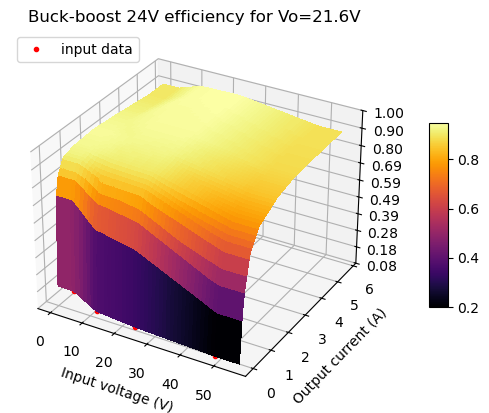

In [11]:
rov.plot_interp("Buck-boost 24V", plot3d=True, cmap="inferno");

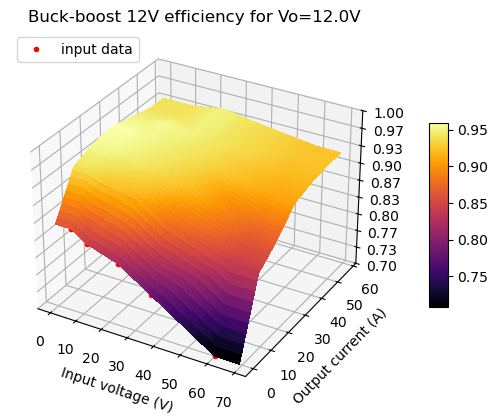

In [12]:
rov.plot_interp("Buck-boost 12V", plot3d=True, cmap="inferno");

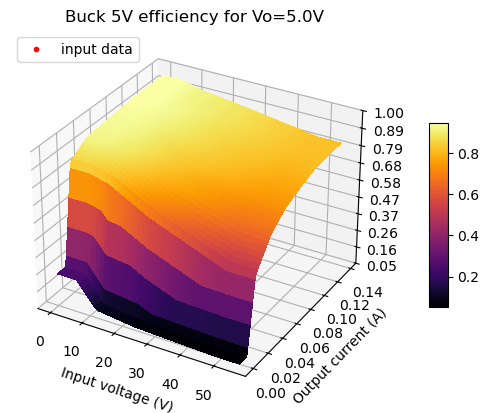

In [13]:
rov.plot_interp("Buck 5V", plot3d=True, cmap="inferno");

All looks good, so we can start with system analysis.

## Analysis
We will analyze all possible battery pack configurations except all batteries in parallel and all in series. The battery voltage of rechargeable lithium batteries varies quite a lot from fully charged state to almost depleted state. Thus, we also run analysis with minimum, nominal and maximum battery voltage.

In [14]:
battery_configs = {"12x2": [12, 2], "8x3": [8, 3], "6x4": [6, 4], "4x6": [4,6], "3x8": [3,8], "2x12" :[2,12]}
battery_state = {"max":BATT_MAX, "nom":BATT_NOM, "min":BATT_MIN}
res = []
for bc in list(battery_configs.keys()):
    for bs in list(battery_state.keys()):
        conf = battery_configs[bc]
        bstate = battery_state[bs]
        rov = create_rov(conf[0], conf[1], BATT_RC, 50e-3, bstate, BATT_CAP, rov_phases)
        res += [rov.solve(tags={"Pack":bc, "Voltage":bs+": "+str(round(bstate*conf[1],1))})]
df = pd.concat(res, ignore_index=True)

Let's look at ROV average power consumption as a function of battery pack configuration (nominal battery voltage):

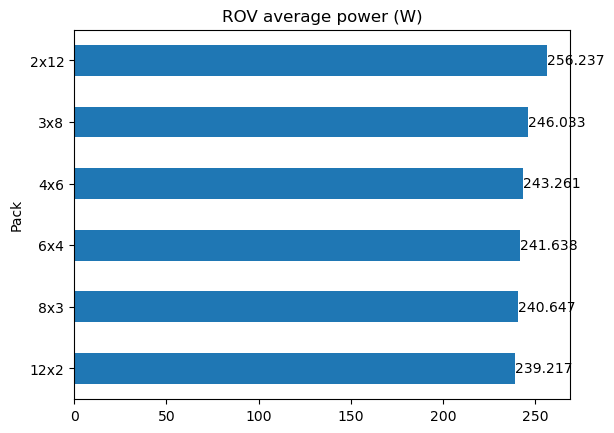

In [15]:
ax = df[(df.Component == "System average") & (df.Voltage.str.startswith("nom"))].plot.barh(x="Pack", y="Power (W)", legend=False, title="ROV average power (W)")
ax.bar_label(ax.containers[0]);

According to the results above, the lower battery pack voltages result in the lowest energy consumption. Let's take a closer look at the results:

In [16]:
df[(df.Component == "System average") & (df.Voltage.str.startswith("nom"))][["Component", "Phase", "Pack", "Voltage", "Iout (A)", "Power (W)", "Loss (W)", "Efficiency (%)"]].style.hide(axis='index')

Component,Phase,Pack,Voltage,Iout (A),Power (W),Loss (W),Efficiency (%)
System average,,12x2,nom: 7.4,32.326685,239.217466,29.036697,88.186986
System average,,8x3,nom: 11.1,21.679953,240.647474,30.466705,87.632961
System average,,6x4,nom: 14.8,16.326884,241.637890,31.457122,87.280612
System average,,4x6,nom: 22.2,10.957709,243.261129,33.080361,86.697295
System average,,3x8,nom: 29.6,8.311939,246.033384,35.852617,85.662015
System average,,2x12,nom: 44.4,5.771106,256.237115,46.056338,82.061593


But before taking a decision on the battery pack configuration, we should check for warnings. Warnings occur whenever limits we defined for some of the components are exceeded:

In [17]:
cols = df.columns.to_list()
cols.remove("Type")
cols.remove("Parent")
df[(df.Warnings != "") & (df.Type != "")][cols].style.hide(axis='index')

Component,Pack,Voltage,Phase,Vin (V),Vout (V),Iin (A),Iout (A),Power (W),Loss (W),Efficiency (%),Temp. rise (°C),Peak temp. (°C),Warnings
BattPack,12x2,min: 6.0,roam,6.000000,5.067966,62.135618,62.135618,372.813706,57.912525,84.466096,,,io
Buck-boost 12V,12x2,min: 6.0,roam,5.067966,12.000000,60.113753,24.300000,304.654443,13.054443,95.715000,19.581664,44.581664,vi
Buck-boost 12V,12x2,min: 6.0,scan,5.510241,12.000000,28.392056,12.300000,156.447083,8.847083,94.345000,13.270624,38.270624,vi
Buck-boost 12V,12x2,min: 6.0,inspect,5.339428,12.000000,38.214460,16.140000,204.043362,10.363362,94.921000,15.545044,40.545044,vi
BattPack,8x3,min: 9.0,roam,9.000000,7.598284,41.532312,41.532312,373.790806,58.216486,84.425383,,,io
BattPack,6x4,min: 12.0,roam,12.000000,10.123928,31.267871,31.267871,375.214457,58.660787,84.366064,,,io
BattPack,4x6,min: 18.0,roam,18.000000,15.166674,20.987600,20.987600,377.776792,59.464710,84.259300,,,io
BattPack,3x8,min: 24.0,roam,24.000000,20.201132,15.828618,15.828618,379.886822,60.130832,84.171382,,,io
Buck-boost 12V,2x12,max: 50.4,roam,46.486737,12.000000,6.929172,24.300000,322.114594,30.514594,90.526789,45.771890,70.771890,tr
Buck-boost 24V,2x12,max: 50.4,scan,48.185106,21.600000,0.568106,0.984074,27.374245,6.118245,77.649630,4.894596,29.894596,pl


The warnings column in the table above is interpreted as follows:
  * *vi* on the Buck-boost 12V converter means that the input voltage is too low for the converter. This occurs when the battery cells are almost depleted.
  * *io* on the BattPack means that the current drawn from battery cells exceed the desired max current of 1C
  * *pl* on the Buck-boost 24V converter means that the power dissipation in this converter is too high (the limit is 6W)
  * *tr* on the Buck-boost 12V means that the temperature rise is too high (the limit is 40°C)

System engineering is all about compromises, so all these warnings could probably be mitigated in one way or the other. All configurations have a warning on *io* on the battery pack current, which exceeds 1C, but not with a large factor. In this case we decided to go for the 8x3 battery pack configuration. It has the second lowest energy consumption, and the maximum cell current is 5.19A in the roaming phase.

## Battery life estimation
The next task is to estimate battery life with the 8x3 battery pack. We will use a PyBaMM model as described previously in the [Battery Life Simulation tutorial](batt_life_sim). Start by installing PyBaMM.

In [18]:
%pip install pybamm -q
import pybamm

Note: you may need to restart the kernel to use updated packages.


First, let's calculate the battery life with an ideal battery of capacity 40Ah and nominal voltage 11.1V:

In [19]:
40 * 60 / df[(df.Component == "System average") & (df.Voltage == "nom: 11.1")]["Iout (A)"].values[0]

110.70134879136235

110.7 minutes is almost 2 hours.  

Next, we define the callback functions we need to interface with the PyBaMM model. We will simulate a single battery cell, and scale this to the 8x3 configuration, assuming all cells are identical. 

In [20]:
# initialize PyBaMM model
model = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues("Chen2020") # 5Ah model
parameter_values.update({"Current function [A]": "[input]"})
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sim.step(1e-6, inputs={"Current function [A]":0.0}) # dummy step to initialize variables

def probe_pb():
    """Battery probe callback function"""
    sol = sim.solution
    cap = parameter_values["Nominal cell capacity [A.h]"]
    rs = 3 * (2 * BATT_RC + sol["Local ECM resistance [Ohm]"].entries[-1]) / 8 # 8x3 pack
    return (max(cap - sol["Discharge capacity [A.h]"].entries[-1], 0.0) * 24, 
            sol["Voltage [V]"].entries[-1] * 3, 
            rs)

def deplete_pb(t, curr):
    """Battery depletion callback function"""
    sim.step(t, solver=pybamm.CasadiSolver(mode="safe"), inputs={"Current function [A]":curr / 8})
    return probe_pb()

In [21]:
rov =  create_rov(8, 3, 20e-3, 50e-3, BATT_NOM, BATT_CAP, rov_phases)
bldf = rov.batt_life("BattPack", cutoff=7.51, pfunc=probe_pb, dfunc=deplete_pb)

Battery depletion (Ah):   0%|          | 0.00/120 [00:00<?, ?Ah/s]

With the PyBaMM model, the battery life is:

In [22]:
bldf["Time (s)"].values[-1] / 60

102.5

102.5 minutes. Let's look at the battery pack voltage as a function of time:

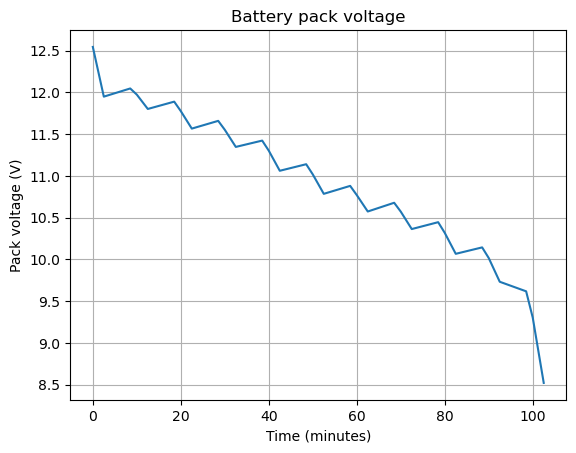

In [23]:
plt.plot(bldf["Time (s)"]/60, bldf["Voltage (V)"])
plt.title("Battery pack voltage")
plt.xlabel("Time (minutes)")
plt.ylabel("Pack voltage (V)")
plt.grid();

A general challenge with synchronizing two models (system model and PyBaMM battery model) is how often the two models should be synchronized with each other. With the current definition of load phases, the next phase is analyzed with the battery voltage at the end of the previous phase. This is not correct, as the battery voltage changes during each phase. One way to increase accuracy is to split each phase in two, e.g. 20:80%. The battery voltage will then "settle" the first 20% of the interval allow the remainer 80% to be analyzed with a more accurate cell voltage. Let's see how much impact this will have on the battery life estimation:

In [24]:
SPLIT = 0.2
rov_phases2 = {"roam1": 150*SPLIT, "roam2": 150*(1-SPLIT), 
              "scan1": 360*SPLIT, "scan2": 360*(1-SPLIT),
              "inspect1": 90*SPLIT, "inspect2": 90*(1-SPLIT)}
rov.set_sys_phases(rov_phases2)
rov.set_comp_phases("Light", phase_conf={"roam1": 0.396, "roam2": 0.396, "scan1": 0.66, "scan2": 0.66, "inspect1":1.32, "inspect2":1.32})
rov.set_comp_phases("Sonar", phase_conf={"scan1": 7.0, "scan2": 7.0})
rov.set_comp_phases("Thrusters", phase_conf={"roam1": 24.0, "roam2": 24.0, "scan1": 12.0, "scan2": 12.0, "inspect1":15.84, "inspect2":15.84})

In [25]:
model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sim.step(1e-6, inputs={"Current function [A]":0.0}) # dummy step to initialize variables
bldf2 = rov.batt_life("BattPack", cutoff=7.51, pfunc=probe_pb, dfunc=deplete_pb)

Battery depletion (Ah):   0%|          | 0.00/120 [00:00<?, ?Ah/s]

In [26]:
bldf2["Time (s)"].values[-1] / 60

103.7

The battery life increased by 1.2 minutes - a very small change. Compare voltage curves for the two battery depletions:

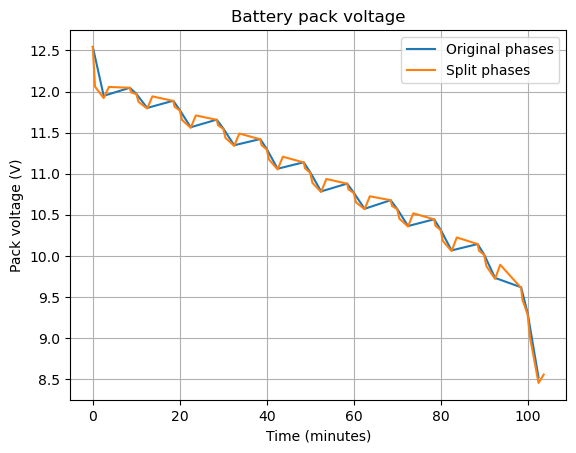

In [27]:
plt.plot(bldf["Time (s)"]/60, bldf["Voltage (V)"], label = "Original phases")
plt.plot(bldf2["Time (s)"]/60, bldf2["Voltage (V)"], label="Split phases")
plt.title("Battery pack voltage")
plt.xlabel("Time (minutes)")
plt.ylabel("Pack voltage (V)")
plt.legend()
plt.grid();

## Summary
This tutorial demonstrates how `sysLoss` can be used to find the optimal battery pack configuration when a set of system use cases are given. It also demonstrates how to estimate battery life with PyBaMM battery models.